In [1]:
import math
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
from src import *
from time import time
import sys
import seaborn as sns

In [2]:
# read data and preprocessing into \Delta(Log(·)) version (almost equals to return rate)
df = pd.read_csv("index_data.csv")
df_delta = df.apply(func = lambda x : x[1:] if x.dtype == object else np.diff(np.log(x)))
Index_name = ['CSI1000', 'CSI500', 'CYB', 'HS300', 'SH50']
date, data = pd.to_datetime(df.date), np.array(df[Index_name]).astype(np.float64)

### Part Ⅰ: Index Data Property

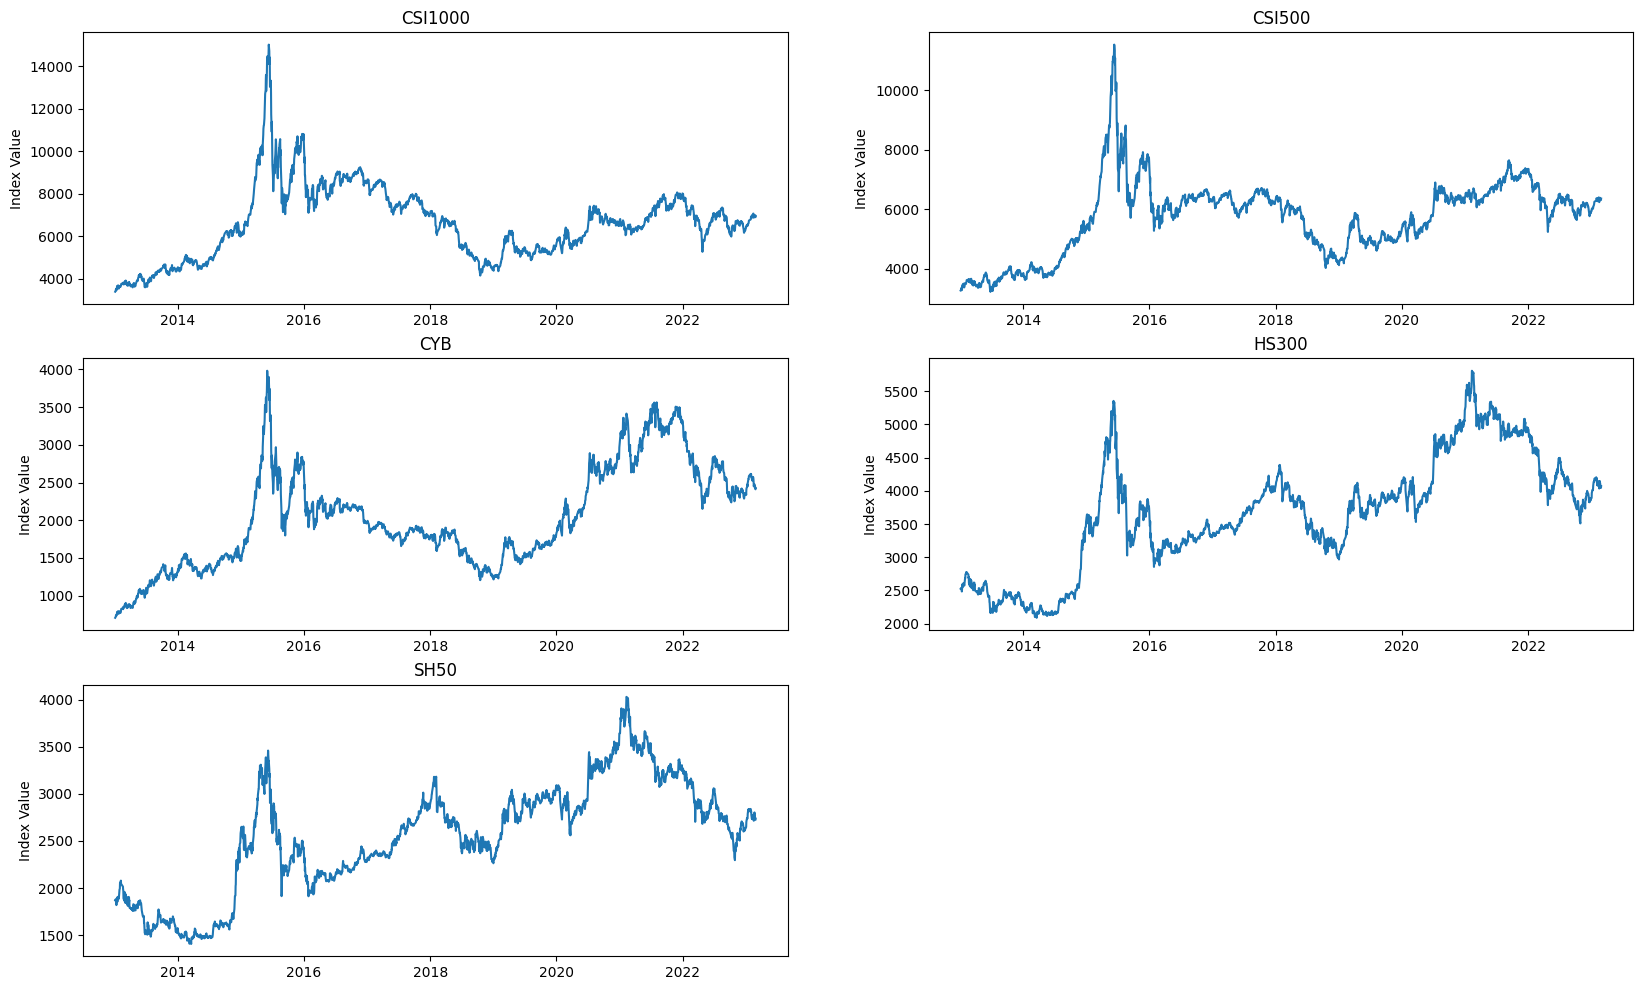

In [3]:
# Index Value
plt.figure(figsize=(20, 12))
for index, index_name in enumerate(Index_name):
    plt.subplot(3, 2, index + 1)
    plt.plot(date[::], df[[index_name]][::])
    plt.title(index_name)
    plt.ylabel('Index Value')

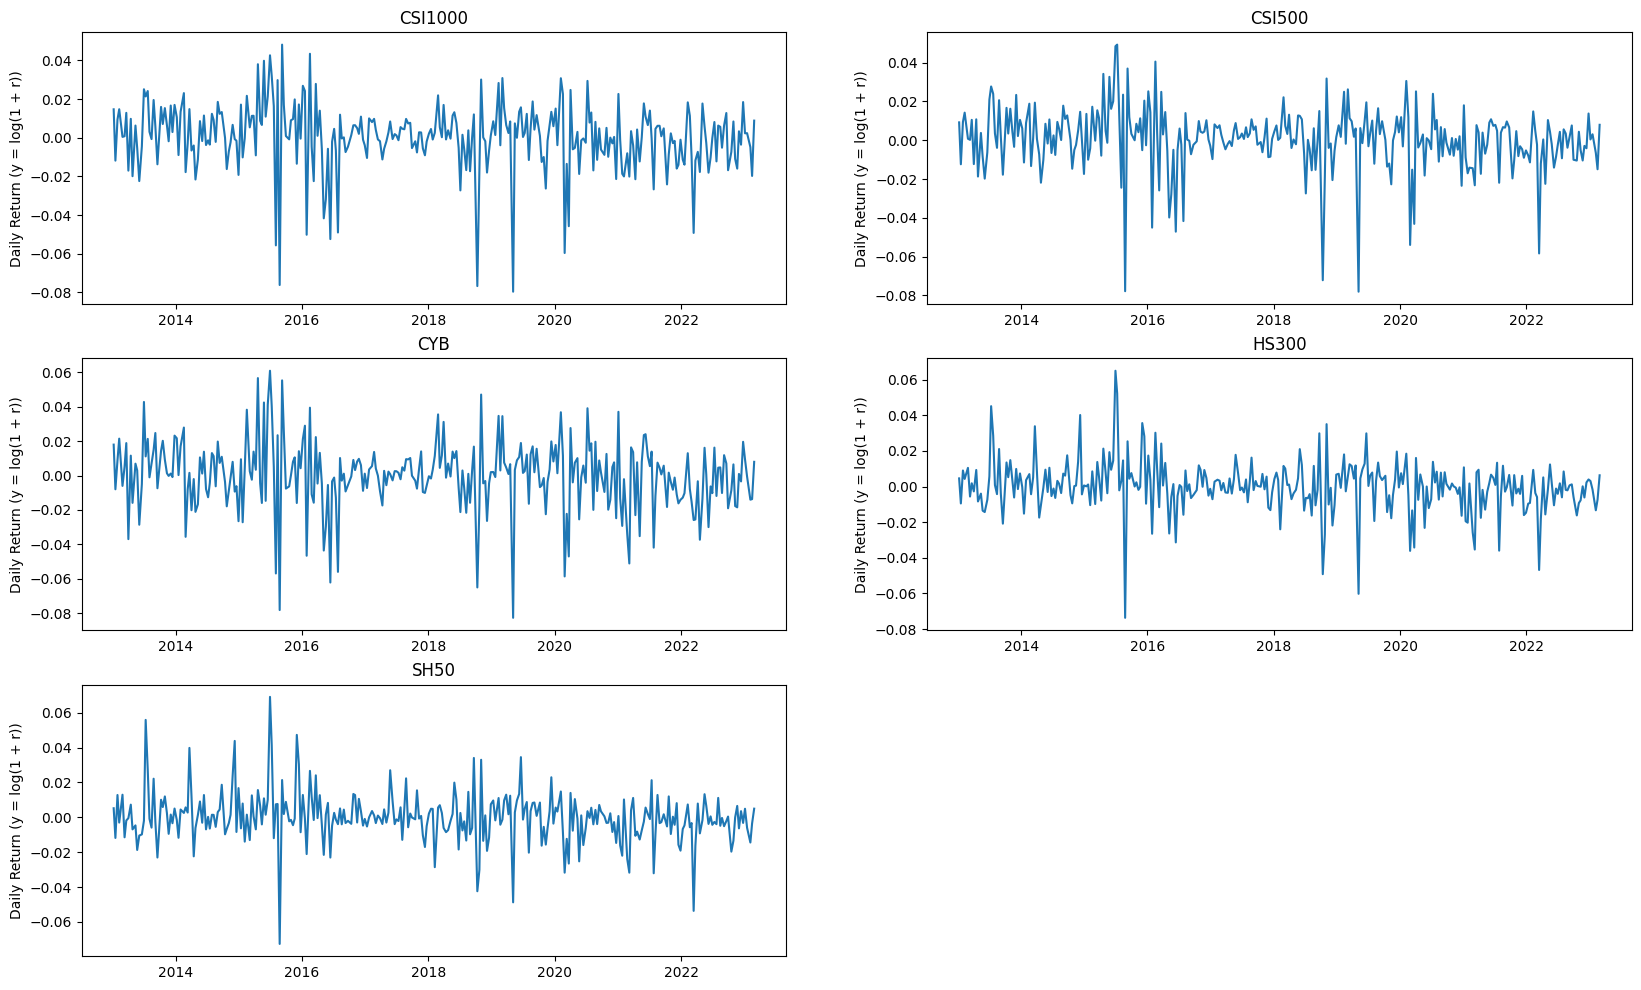

In [4]:
# Index Return
plt.figure(figsize=(20, 12))
for index, index_name in enumerate(Index_name):
    plt.subplot(3, 2, index + 1)
    plt.plot(date[1::8], df_delta[[index_name]][::8])
    plt.title(index_name)
    plt.ylabel('Daily Return (y = log(1 + r))')

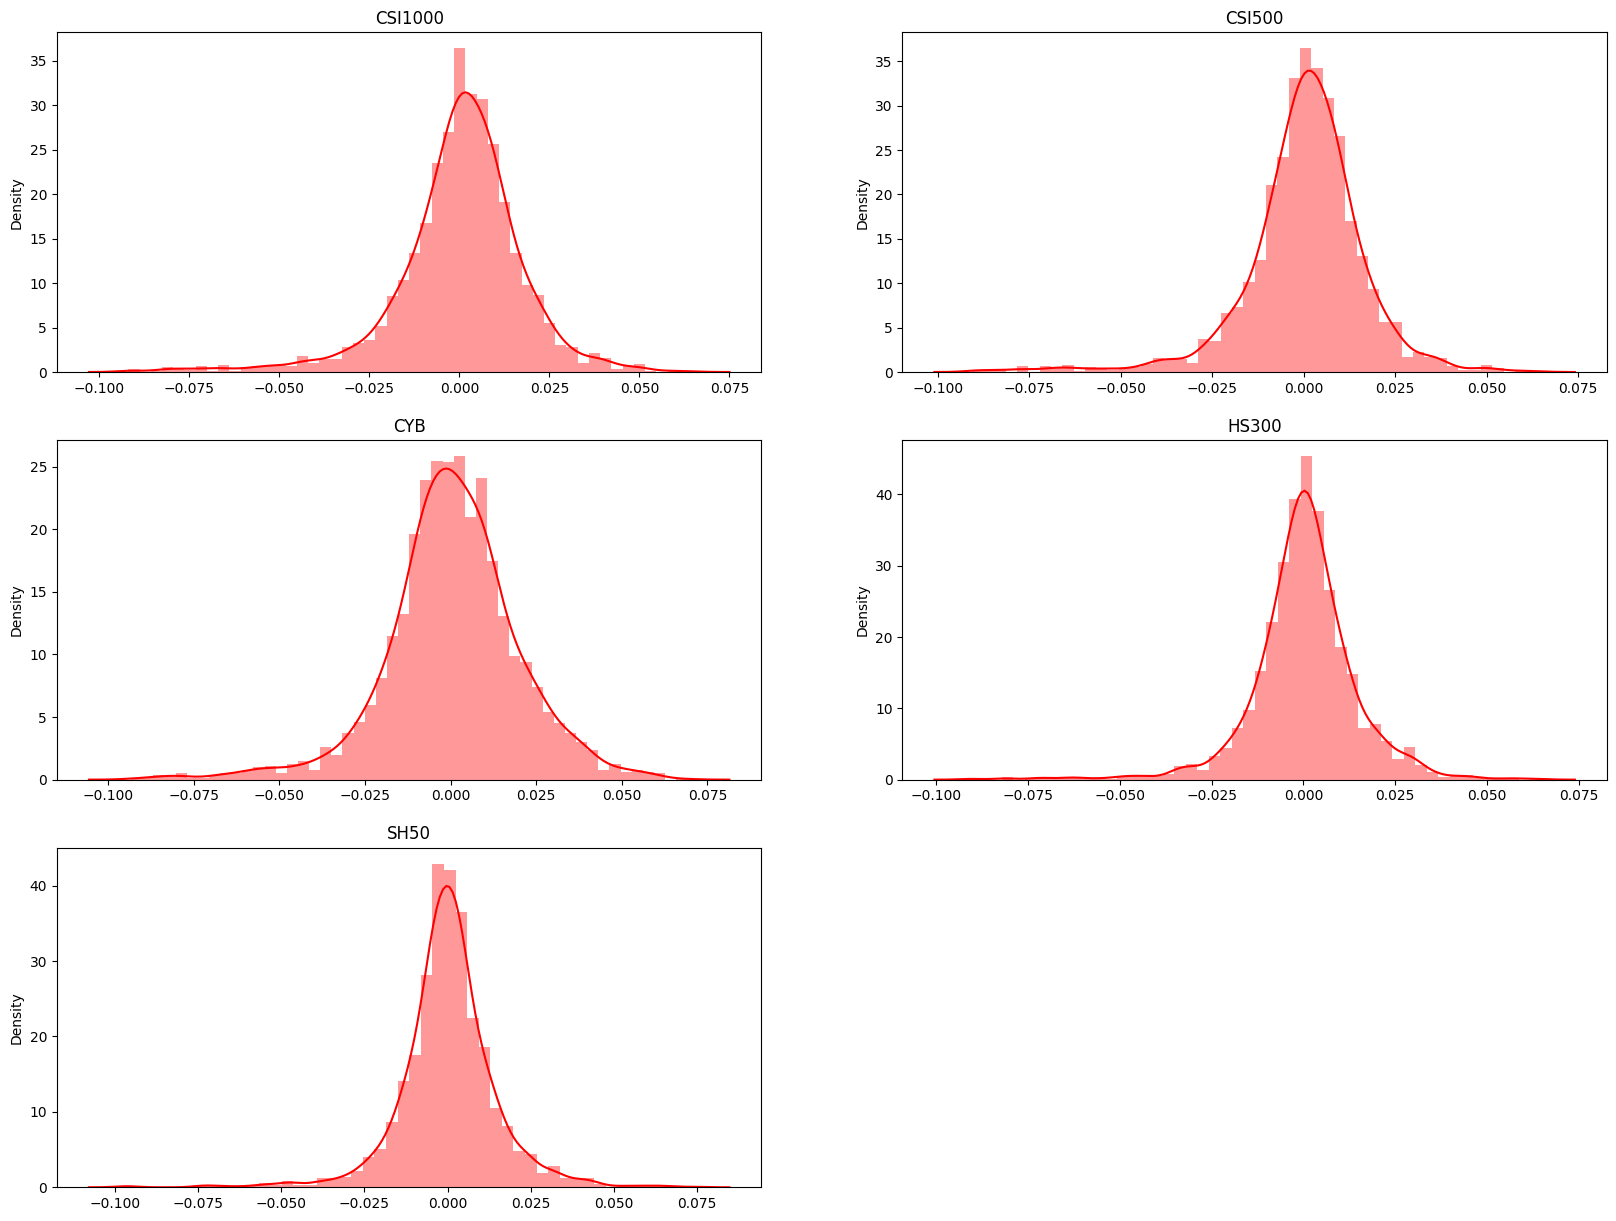

In [5]:
import warnings
warnings.filterwarnings('ignore')
plt.figure(figsize=(20, 15))
for index, index_name in enumerate(Index_name):
  plt.subplot(3, 2, index + 1)
  sns.distplot(df_delta[[index_name]].dropna(), color = "red")
  plt.title(index_name)

<Axes: >

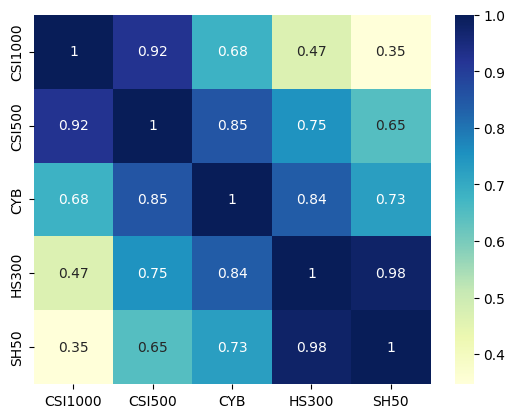

In [6]:


sns.heatmap(
    df[Index_name].corr(), 
    annot=True, 
    cmap="YlGnBu"
)

<Axes: >

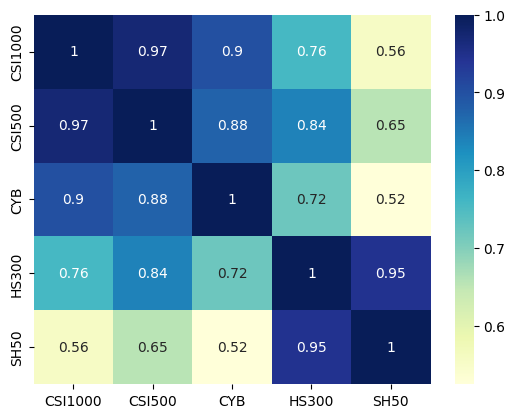

In [7]:
sns.heatmap(
    df_delta[Index_name].corr(), 
    annot=True, 
    cmap="YlGnBu"
)

### Part Ⅱ : Models on Data

In [13]:
def show_metrics(metrics, title):
    f,ax = plt.subplots()
    sns.heatmap([[metrics["TP"], metrics["FP"]], [metrics["FN"], metrics["TN"]]], annot = True, ax = ax)
    ax.set_title('Seaborn Confusion Matrix with labels\n\n')
    ax.set_xlabel('predict') 
    ax.set_ylabel('true') 
    plt.show()
    print('------------------------------------------------')
    print(f"Title {title}'s metrics: {metrics}")
    

def show_everything_about_a_specific_model_and_index_set(model_select = "all", index_set = [0, 1, 2, 3, 4], epochs = 100):
    """
        model_select : `all` / `lstm` / `arima` / `xgboost`
        index_set : subset of [0, 1, 2, 3, 4] (0->CSI1000, 1->CSI500, 2->CYB, 3->HS300, 4->SH50)

    """
    data = np.array(df_delta[['CSI1000', 'CSI500', 'CYB', 'HS300', 'SH50']]).astype(np.float64)
    daily_data = trans(raw_data = data, length = 931, interval = 1, after = 30)
    two_week_data = trans(raw_data = data, length = 931, interval = 15, after = 30)
    # after -> predict how many days after the final observed day
    # interval -> the interval of the two days we use to compute the return rate
    print(daily_data.shape, daily_data.dtype)
    print(two_week_data.shape, two_week_data.dtype)


    # MODEL
    model = GlobalModel(
                TYPE = model_select, 
                index_set = index_set
            )

    # Train Processing
    _, train_loss_list, dev_loss_list = model.train(
        data = daily_data, 
        xgb_data = two_week_data, 
        train_index = np.arange(1000), 
        dev_index = np.arange(1000, 1300), 
        device = model.gpu,
        epochs = epochs,
        learning_rate = 3 * 1e-3
    )

    # Plot Loss of train and dev
    sns.set_theme(style="darkgrid")
    df = pd.DataFrame(
            [
                [i + 1 for i in range(epochs)]*2, 
                ["train"]*epochs + ["dev"]*epochs, 
                train_loss_list + dev_loss_list
            ], 
            ["epoch", "type", "Loss"]
        )
    sns.lineplot(x = "epoch", y = "Loss",
                hue = "type",
                data=df.T)
    
    # Show metrics on Train and Test
    train_dataset_metrics = model.test(daily_data, two_week_data, np.arange(1000), model.gpu)
    test_dataset_metrics = model.test(daily_data, two_week_data, np.arange(1000, 1300), model.gpu)
    show_metrics(train_dataset_metrics, "TRAIN")
    show_metrics(test_dataset_metrics, "TEST")

    # Finally Report the accuracy
    print("***********************************************")
    train_acc, test_acc = train_dataset_metrics["acc"], test_dataset_metrics["acc"]
    print(f"Model `{model_select}` on index_set `{index_set}` have results:\n    Train Acc : {train_acc}\n    Test Acc : {test_acc}")


(1535, 5, 902) float64
(1535, 5, 61) float64
(Training) Epoch: 0 Average data point Loss(MSE): 0.006484
(Dev Dataset) Epoch: 0 Average data point Loss(MSE): 0.004657
(Training) Epoch: 1 Average data point Loss(MSE): 0.005570
(Dev Dataset) Epoch: 1 Average data point Loss(MSE): 0.004943
(Training) Epoch: 2 Average data point Loss(MSE): 0.005424
(Dev Dataset) Epoch: 2 Average data point Loss(MSE): 0.004947
(Training) Epoch: 3 Average data point Loss(MSE): 0.005263
(Dev Dataset) Epoch: 3 Average data point Loss(MSE): 0.004631
(Training) Epoch: 4 Average data point Loss(MSE): 0.005163
(Dev Dataset) Epoch: 4 Average data point Loss(MSE): 0.005060
(Training) Epoch: 5 Average data point Loss(MSE): 0.005014
(Dev Dataset) Epoch: 5 Average data point Loss(MSE): 0.005534
(Training) Epoch: 6 Average data point Loss(MSE): 0.004864
(Dev Dataset) Epoch: 6 Average data point Loss(MSE): 0.005763
(Training) Epoch: 7 Average data point Loss(MSE): 0.004774
(Dev Dataset) Epoch: 7 Average data point Loss(MS

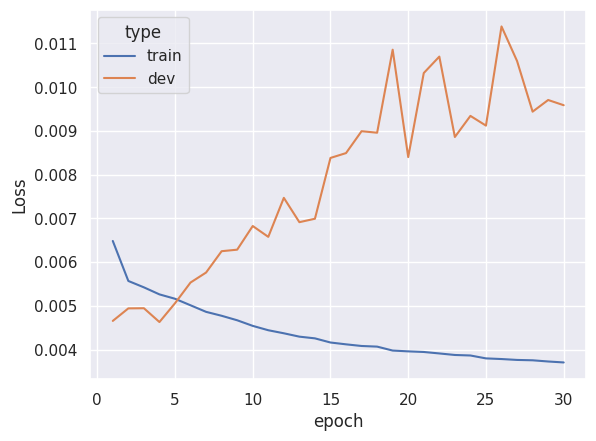

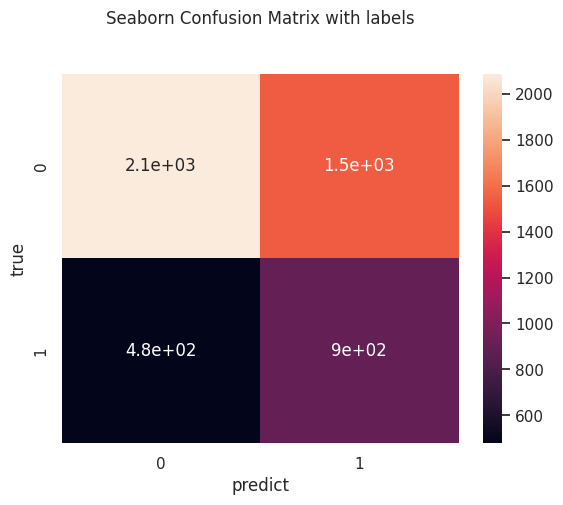

------------------------------------------------
Title TRAIN's metrics: {'TP': 2087, 'TN': 897, 'FP': 1537, 'FN': 479, 'acc': 0.5968, 'prec_1': 0.5758830022075055, 'recall_1': 0.813328137178488, 'f1-score_1': 0.674313408723748, 'prec_0': 0.6518895348837209, 'recall_0': 0.3685291700903862, 'f1-score_0': 0.4708661417322834}


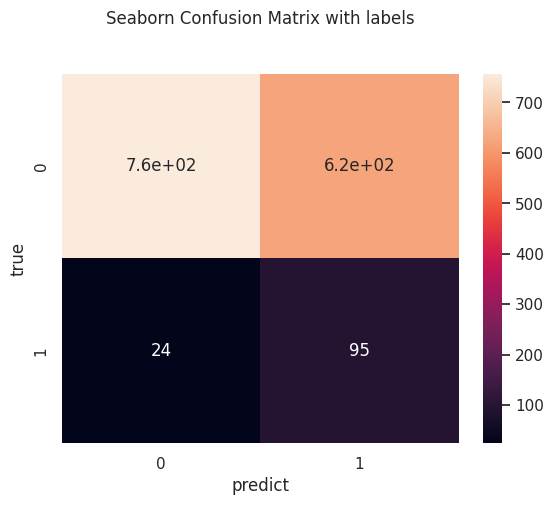

------------------------------------------------
Title TEST's metrics: {'TP': 757, 'TN': 95, 'FP': 624, 'FN': 24, 'acc': 0.568, 'prec_1': 0.5481535119478639, 'recall_1': 0.969270166453265, 'f1-score_1': 0.7002775208140611, 'prec_0': 0.7983193277310925, 'recall_0': 0.13212795549374132, 'f1-score_0': 0.22673031026252985}
***********************************************
Model `arima` on index_set `[0, 1, 2, 3, 4]` have results:
    Train Acc : 0.5968
    Test Acc : 0.568


In [14]:
show_everything_about_a_specific_model_and_index_set("arima", [0, 1, 2, 3, 4], 30)

(1535, 5, 902) float64
(1535, 5, 61) float64
(Training) Epoch: 0 Average data point Loss(MSE): 0.000305
(Dev Dataset) Epoch: 0 Average data point Loss(MSE): 0.004482
total time = 0.6925911903381348 s


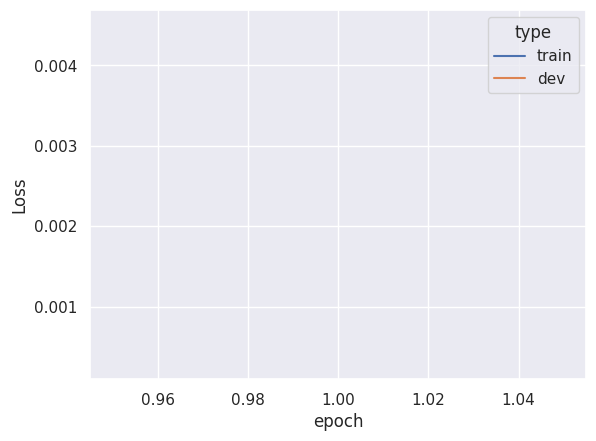

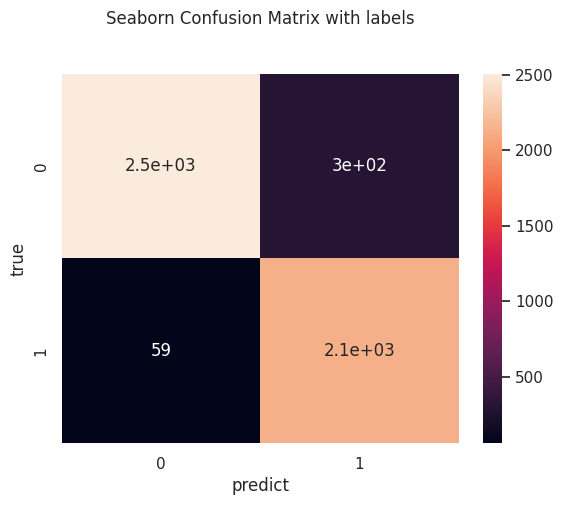

------------------------------------------------
Title TRAIN's metrics: {'TP': 2507, 'TN': 2130, 'FP': 304, 'FN': 59, 'acc': 0.9274, 'prec_1': 0.8918534329420135, 'recall_1': 0.9770070148090413, 'f1-score_1': 0.9324902361911847, 'prec_0': 0.9730470534490635, 'recall_0': 0.8751027115858668, 'f1-score_0': 0.9214795587280986}


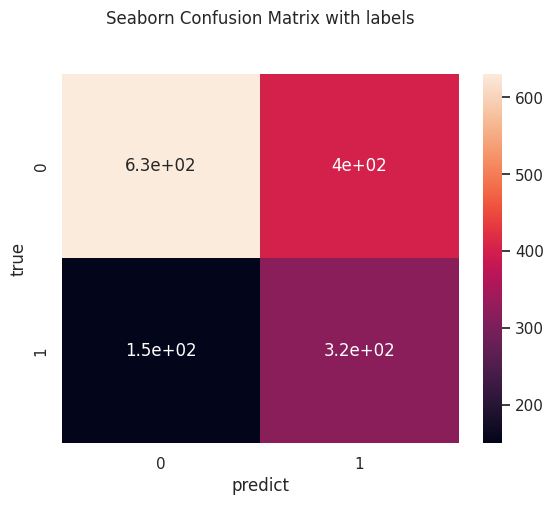

------------------------------------------------
Title TEST's metrics: {'TP': 631, 'TN': 317, 'FP': 402, 'FN': 150, 'acc': 0.632, 'prec_1': 0.6108422071636012, 'recall_1': 0.8079385403329066, 'f1-score_1': 0.6957001102535832, 'prec_0': 0.6788008565310493, 'recall_0': 0.44089012517385257, 'f1-score_0': 0.5345699831365937}
***********************************************
Model `xgboost` on index_set `[0, 1, 2, 3, 4]` have results:
    Train Acc : 0.9274
    Test Acc : 0.632


In [15]:
show_everything_about_a_specific_model_and_index_set("xgboost", [0, 1, 2, 3, 4], 1)

(1535, 5, 902) float64
(1535, 5, 61) float64
(Training) Epoch: 0 Average data point Loss(MSE): 0.006225
(Dev Dataset) Epoch: 0 Average data point Loss(MSE): 0.004818
(Training) Epoch: 1 Average data point Loss(MSE): 0.003030
(Dev Dataset) Epoch: 1 Average data point Loss(MSE): 0.004594
(Training) Epoch: 2 Average data point Loss(MSE): 0.002148
(Dev Dataset) Epoch: 2 Average data point Loss(MSE): 0.004417
(Training) Epoch: 3 Average data point Loss(MSE): 0.001596
(Dev Dataset) Epoch: 3 Average data point Loss(MSE): 0.004479
(Training) Epoch: 4 Average data point Loss(MSE): 0.001264
(Dev Dataset) Epoch: 4 Average data point Loss(MSE): 0.004439
(Training) Epoch: 5 Average data point Loss(MSE): 0.001041
(Dev Dataset) Epoch: 5 Average data point Loss(MSE): 0.004430
(Training) Epoch: 6 Average data point Loss(MSE): 0.000907
(Dev Dataset) Epoch: 6 Average data point Loss(MSE): 0.004425
(Training) Epoch: 7 Average data point Loss(MSE): 0.000819
(Dev Dataset) Epoch: 7 Average data point Loss(MS

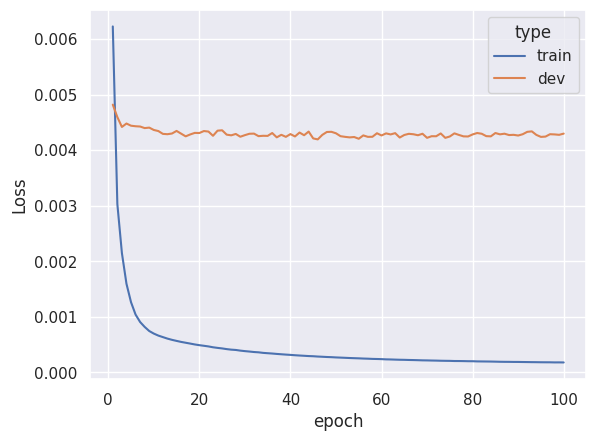

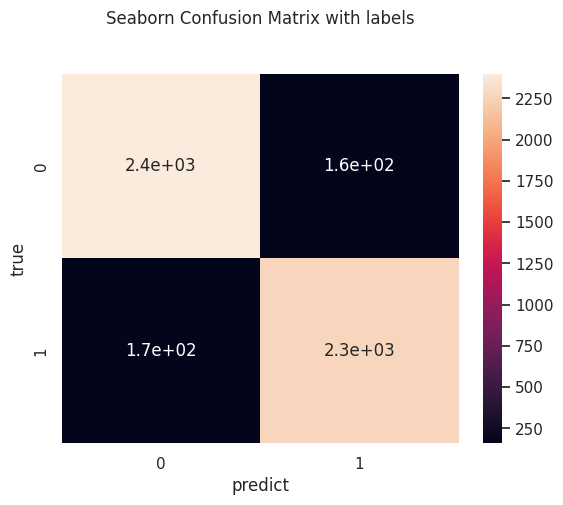

------------------------------------------------
Title TRAIN's metrics: {'TP': 2399, 'TN': 2274, 'FP': 160, 'FN': 167, 'acc': 0.9346, 'prec_1': 0.93747557639703, 'recall_1': 0.9349181605611847, 'f1-score_1': 0.9361951219512195, 'prec_0': 0.9315854158131913, 'recall_0': 0.934264585045193, 'f1-score_0': 0.9329230769230769}


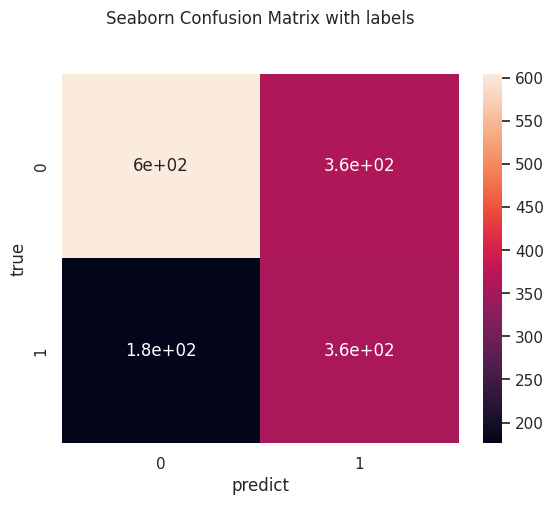

------------------------------------------------
Title TEST's metrics: {'TP': 605, 'TN': 357, 'FP': 362, 'FN': 176, 'acc': 0.6413333333333333, 'prec_1': 0.6256463288521199, 'recall_1': 0.7746478873239436, 'f1-score_1': 0.6922196796338672, 'prec_0': 0.6697936210131332, 'recall_0': 0.4965229485396384, 'f1-score_0': 0.5702875399361023}
***********************************************
Model `all` on index_set `[0, 1, 2, 3, 4]` have results:
    Train Acc : 0.9346
    Test Acc : 0.6413333333333333


In [17]:
show_everything_about_a_specific_model_and_index_set("all", [0, 1, 2, 3, 4], 100)